### Import Library and Data


In [1]:
import pandas as pd
import numpy as np
import sklearn
from pyampute.exploration.mcar_statistical_tests import MCARTest
from pyampute.exploration.md_patterns import mdPatterns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/heizsen/dataset/main/home-data-for-ml-course/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/heizsen/dataset/main/home-data-for-ml-course/test.csv')

In [3]:
# Setting max rows and columns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [4]:
df_train.shape

(1460, 81)

### Data Train Preprocessing

In [5]:
# Mendefinisikan tipe data didalam dataset

ordinal = ['MSSubClass', 'LotShape', 'LandContour', 'LandSlope', 'OverallQual', 
           'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
           'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
           'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu',
           'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 
           'PoolQC', 'Fence','SaleCondition']

nominal = [ 'MSZoning', 'Street', 'Alley','Utilities', 'LotConfig',
            'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
            'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
            'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType',
            'MiscFeature','SaleType', 'MoSold']

interval = ['YearBuilt', 'YearRemodAdd', 'YrSold']

rasio = [ 'Id', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1','BsmtFinSF2', 
            'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
            'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath','HalfBath', 
            'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
            'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
            '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

data_kategorik = nominal + ordinal
data_numerik = interval + rasio


In [6]:
# Pengecekan Missing Value data training

df_train.isna().sum()[df_train.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
# Akan di drop variabel ['Alley', 'PoolQC', 'Fence', 'MiscFeature']

df_train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [8]:
# Mengecek kembali, apakah sudah terhapus 4 variabel sebelumnya
df_train.isna().sum()[df_train.isna().sum() > 0]

LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [9]:
# Uji Randomness missing value dengan Little MCAR

'''
H0: data is Missing Completely At Random (MCAR). 
H1: data is not MCAR

p-value <= alpha ---> Tolak H0
p-value > alpha ---> Gagal Tolak H0
'''

missing_columns = [x for x in df_train.columns if df_train[x].isna().sum() > 0]
MV = df_train[missing_columns]


# Akan dilakukan pengecekan littles MCAR Test untuk 3 variabel berikut

mt = MCARTest(method="little")
mt.little_mcar_test(MV[["LotFrontage", "MasVnrArea", "GarageYrBlt"]])


# Karena data tidak MCAR, maka dilakukan imputasi dengan multiple imputation

imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed = imputer.fit_transform(MV[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']])  

# Hasil imputasi (dalam bentuk array NumPy)
data_imputed_rounded = np.round(data_imputed).astype(int)

# update pada datset utama
df_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']] = pd.DataFrame(data_imputed_rounded)

In [10]:
# Akan melakukan imputasi untuk sisa variabel yang masih ada missing value

mv = [x for x in df_train.columns if df_train[x].isna().sum() > 0 if x not in ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']]

for column in df_train[mv]:
  df_train[column] = df_train[column].fillna(df_train[column].mode()[0])

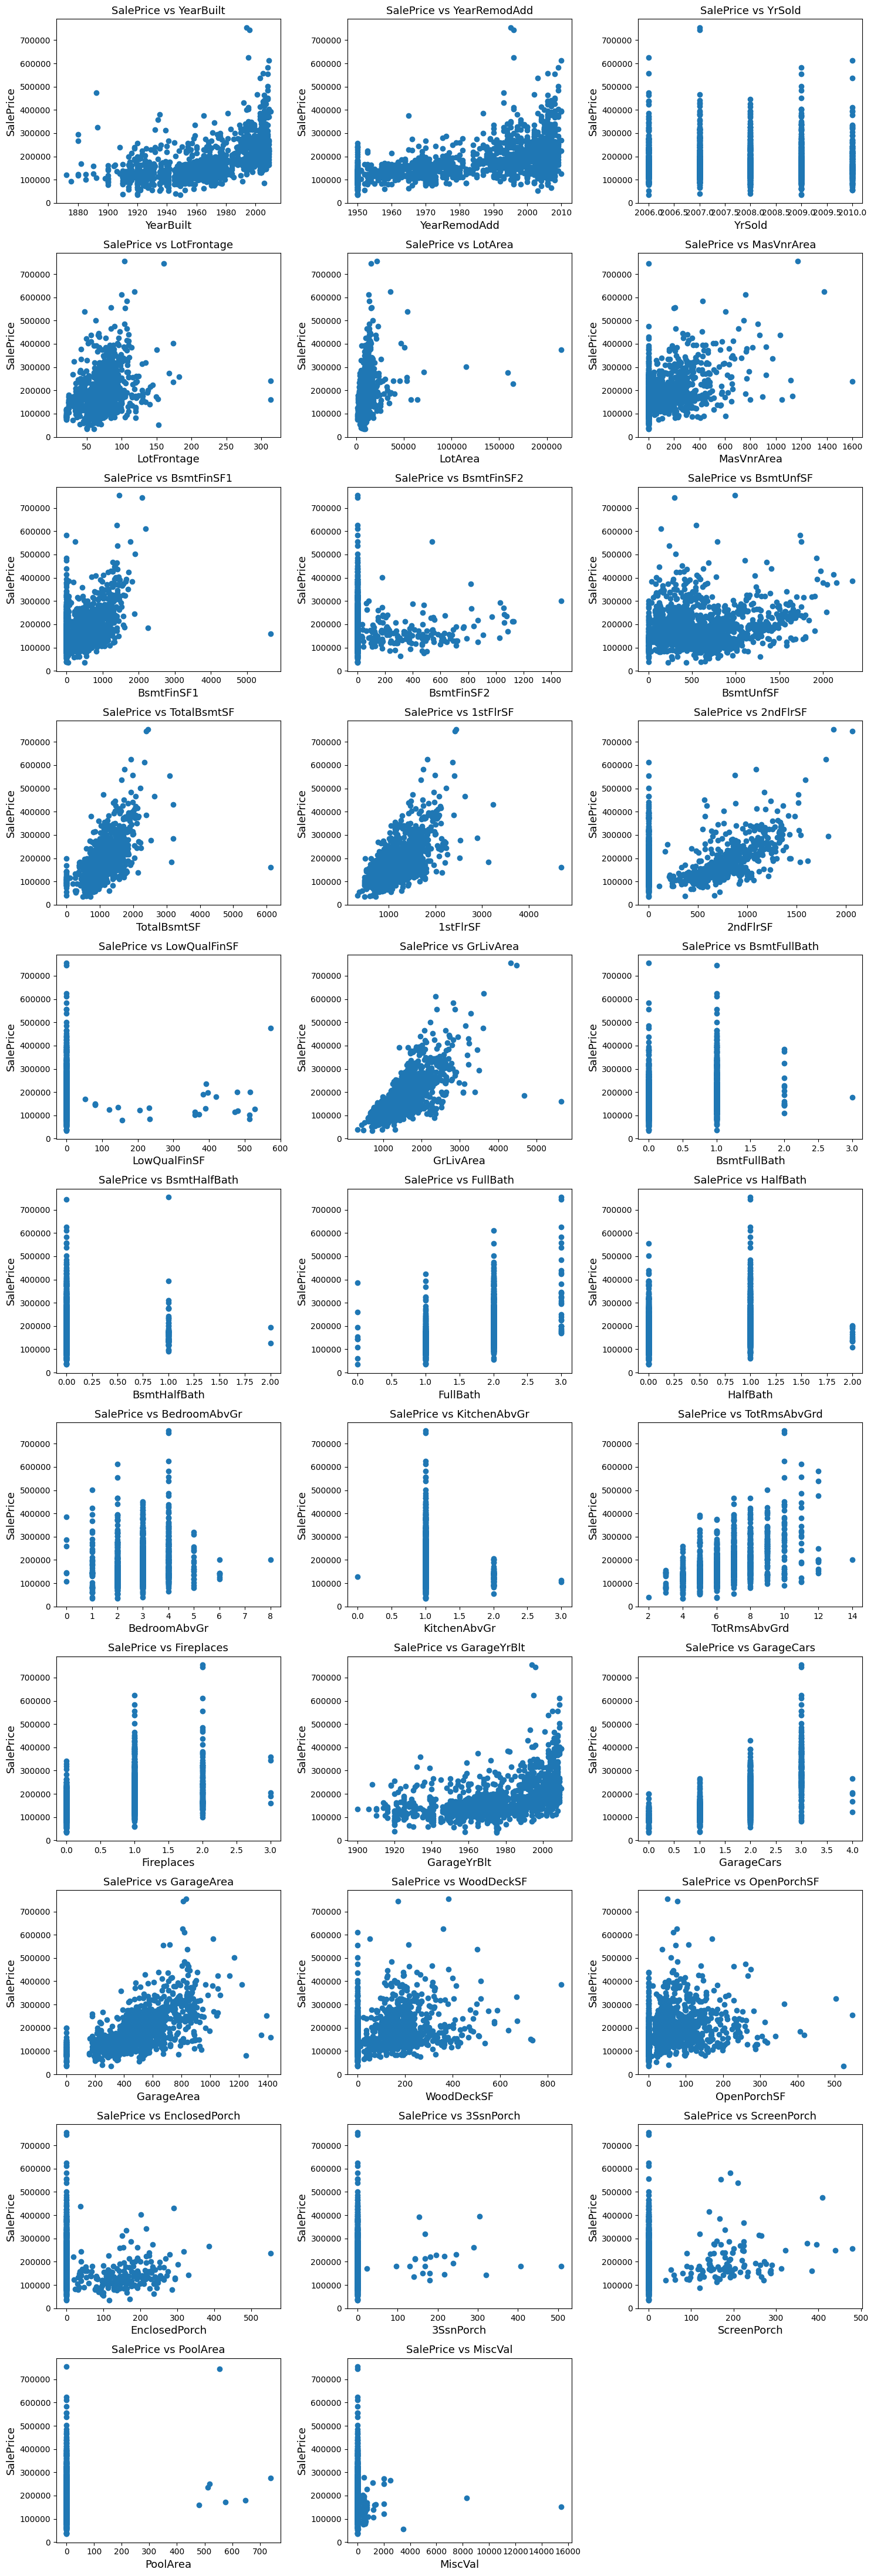

In [11]:
#Pemilihan variabel independen
indep_var = [x for x in df_train[data_numerik] if x not in ['Id', 'SalePrice']]

# Menghitung jumlah baris dan kolom subplot yang dibutuhkan
num_plots = len(indep_var)
num_cols = 3  # Jumlah kolom yang diinginkan (sesuaikan sesuai preferensi)
num_rows = int(np.ceil(num_plots / num_cols))  # Menghitung jumlah baris yang dibutuhkan

# Membuat figure dan axes untuk subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

# Flatten axes jika hanya ada satu baris
axes = axes.flatten()

# Melakukan loop untuk setiap variabel independen
for i, var in enumerate(indep_var):
    axes[i].scatter(df_train[var], df_train['SalePrice'])
    axes[i].set_title(f'SalePrice vs {var}', fontsize=13)
    axes[i].set_xlabel(var, fontsize=13)
    axes[i].set_ylabel('SalePrice', fontsize=13)

# Menghilangkan subplot yang tidak terpakai (jika ada)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menampilkan gambar
plt.tight_layout()
plt.show()

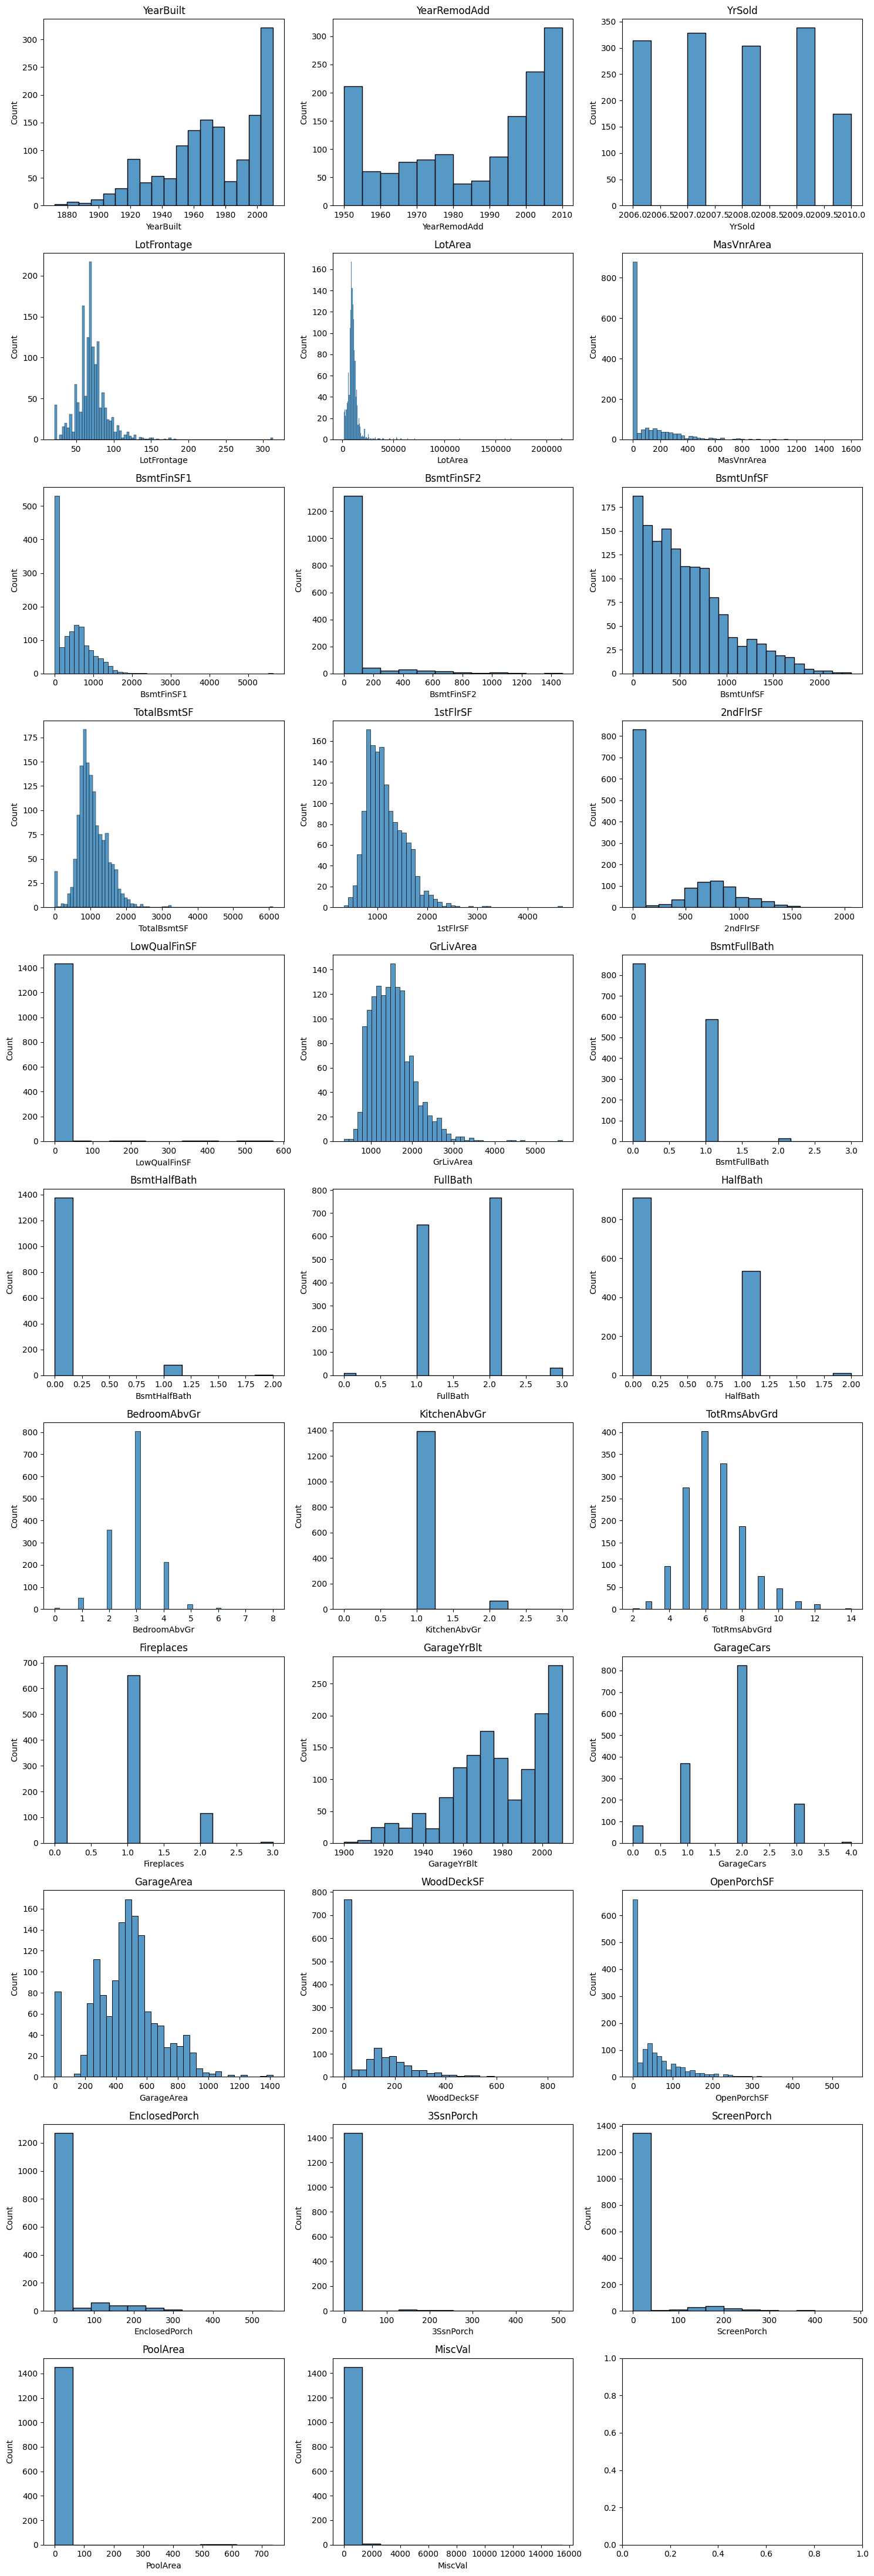

In [12]:
# Menghitung jumlah baris dan kolom subplot yang dibutuhkan
num_plots = len(indep_var)
num_cols = 3  # Jumlah kolom yang diinginkan (sesuaikan sesuai preferensi)
num_rows = int(np.ceil(num_plots / num_cols))  # Menghitung jumlah baris yang dibutuhkan

# Membuat figure dan axes untuk subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

# Flatten axes jika hanya ada satu baris
axes = axes.flatten()

# Melakukan loop untuk setiap variabel independen
for i, var in enumerate(indep_var):
    sns.histplot(df_train[var], ax=axes[i])
    axes[i].set_title(var)

# Menampilkan plot
plt.tight_layout()
plt.show()

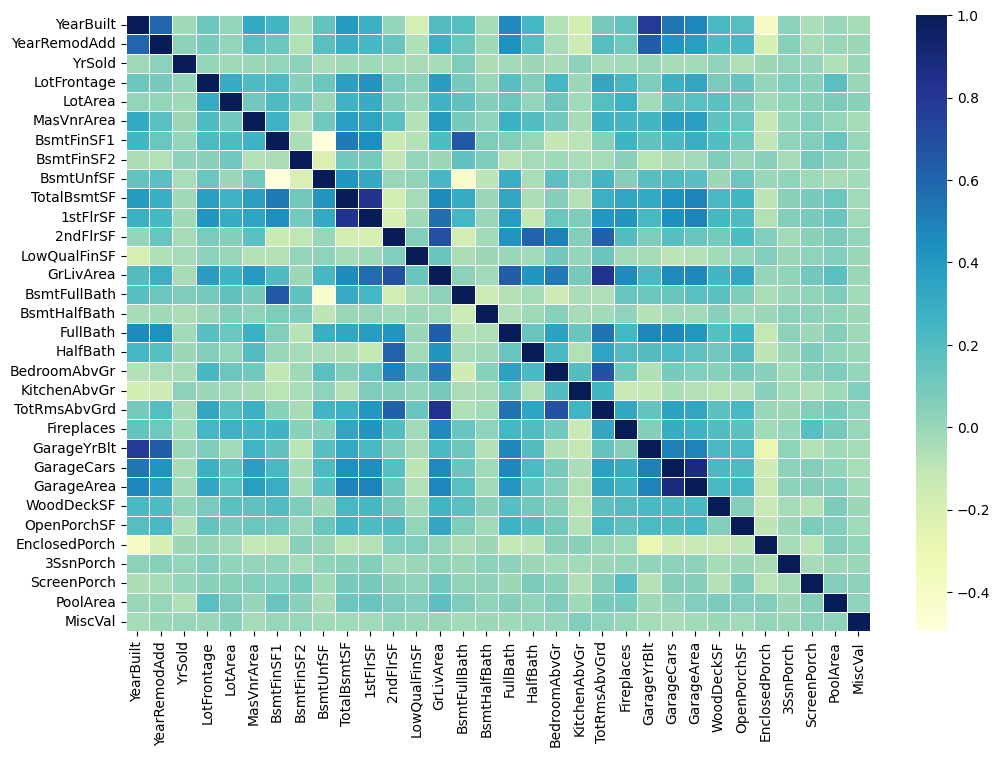

In [13]:
# menampilkan heatmap
correlation_matrix = df_train[indep_var].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.show()

In [14]:
# Drop sebanyak n data pada features diatas
jumlah_drop = {
    'LotFrontage': 5,
    'LotArea': 5,
    'MasVnrArea' : 2,
    'BsmtFinSF1': 1,
    'BsmtFinSF2': 1,
    'BsmtUnfSF' : 1,
    'TotalBsmtSF': 1,
    '1stFlrSF': 1,
    'GrLivArea': 2,
    'MiscVal': 2,
    'GarageArea': 3,
    'OpenPorchSF': 5
    }

# Drop outlier untuk setiap fitur
for feature, n in jumlah_drop.items():
    drop_outlier = df_train.nlargest(n, feature).index
    df_train.drop(drop_outlier, inplace=True)
    


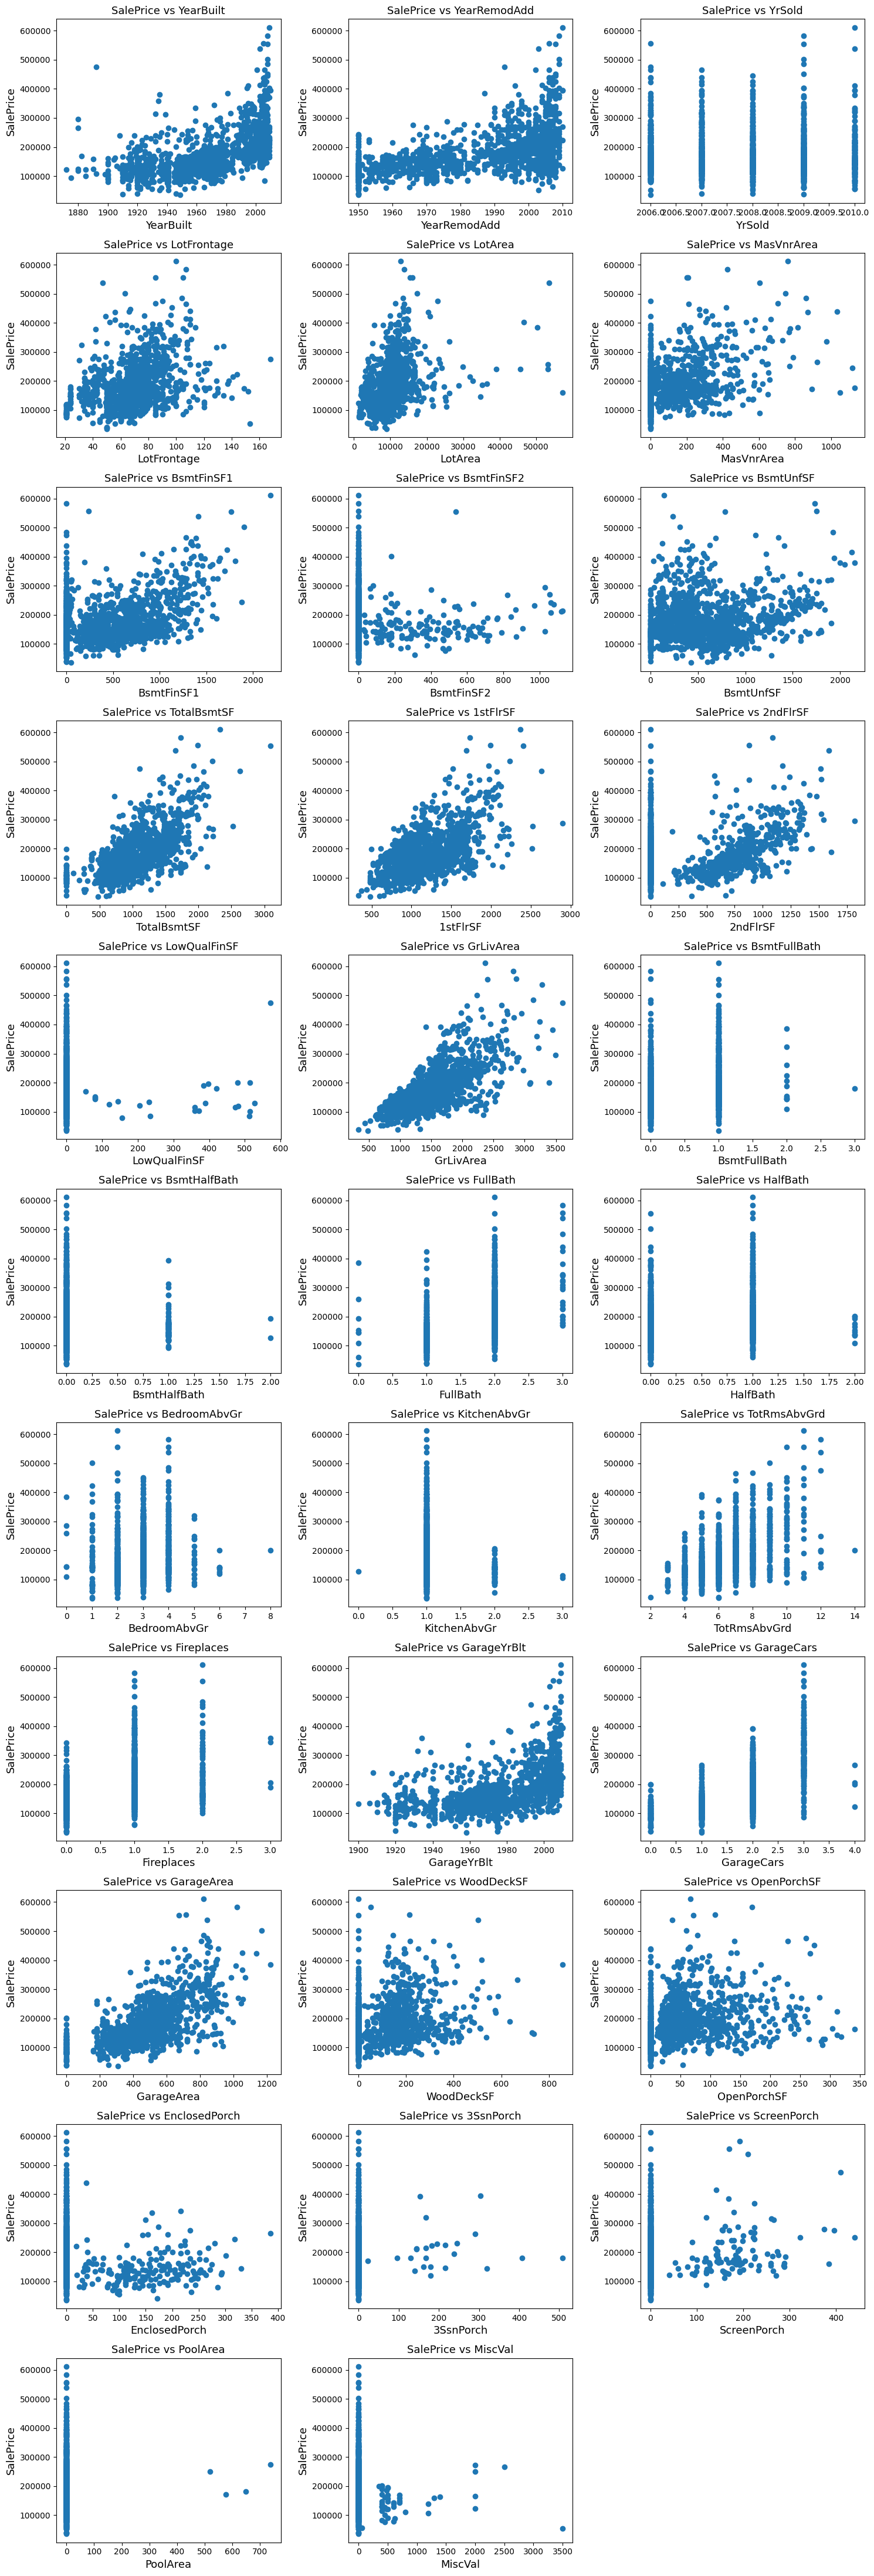

In [16]:
#Pemilihan variabel independen
indep_var = [x for x in df_train[data_numerik] if x not in ['Id', 'SalePrice']]

# Menghitung jumlah baris dan kolom subplot yang dibutuhkan
num_plots = len(indep_var)
num_cols = 3  # Jumlah kolom yang diinginkan (sesuaikan sesuai preferensi)
num_rows = int(np.ceil(num_plots / num_cols))  # Menghitung jumlah baris yang dibutuhkan

# Membuat figure dan axes untuk subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

# Flatten axes jika hanya ada satu baris
axes = axes.flatten()

# Melakukan loop untuk setiap variabel independen
for i, var in enumerate(indep_var):
    axes[i].scatter(df_train[var], df_train['SalePrice'])
    axes[i].set_title(f'SalePrice vs {var}', fontsize=13)
    axes[i].set_xlabel(var, fontsize=13)
    axes[i].set_ylabel('SalePrice', fontsize=13)

# Menghilangkan subplot yang tidak terpakai (jika ada)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menampilkan gambar
plt.tight_layout()
plt.show()

In [17]:
# mengecek multikolinearitas regresi linear berganda

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Membuat DataFrame untuk menyimpan hasil VIF
vif_data = pd.DataFrame()
vif_data["Variabel"] = indep_var

# Menghitung VIF untuk setiap variabel
vif_data["VIF"] = [variance_inflation_factor(df_train[indep_var].values, i) for i in range(df_train[indep_var].shape[1])]
pd.DataFrame(vif_data.round())

c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered

,Variabel,VIF
0,YearBuilt,18931.0
1,YearRemodAdd,18005.0
2,YrSold,22033.0
3,LotFrontage,19.0
4,LotArea,7.0
5,MasVnrArea,2.0
6,BsmtFinSF1,inf
7,BsmtFinSF2,inf
8,BsmtUnfSF,inf
9,TotalBsmtSF,inf


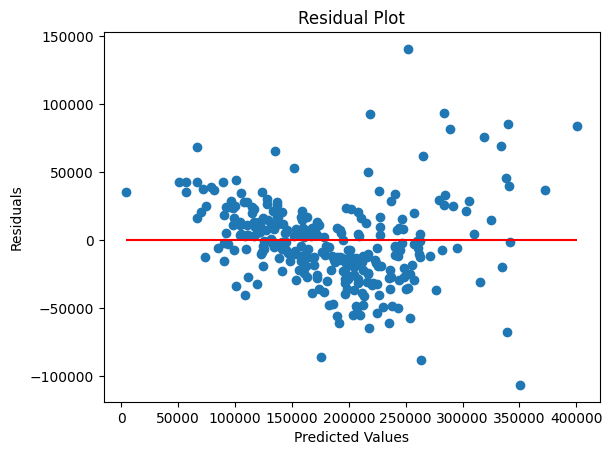

In [18]:
y = df_train['SalePrice']
X = df_train[indep_var]

# Membagi dataset menjadi training 80% dan testing set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 40)

# Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Residuals
residuals_ridge = y_test - y_pred_ridge


# Residual plot
plt.scatter(y_pred_ridge, residuals_ridge)
plt.hlines(y=0, xmin=min(y_pred_ridge), xmax=max(y_pred_ridge), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()



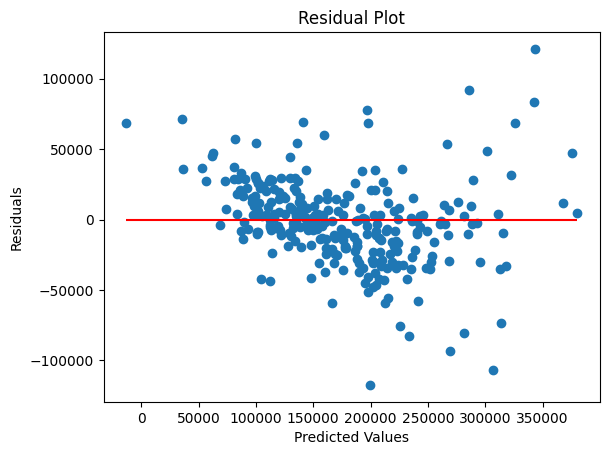

,0
0,169366.724333
1,161609.182223
2,202928.147539
3,112164.745872
4,154818.034155
...,...
282,204624.237849
283,151851.827177
284,143190.524269
285,136833.200596


In [19]:
y = df_train['SalePrice']
X = df_train[indep_var]

# Membagi dataset menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 21)

# Lasso Regression
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Residuals
residuals_lasso = y_test - y_pred_lasso

# Residual plot
plt.scatter(y_pred_lasso, residuals_lasso)
plt.hlines(y=0, xmin=min(y_pred_lasso), xmax=max(y_pred_lasso), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

pd.DataFrame(y_pred_lasso)

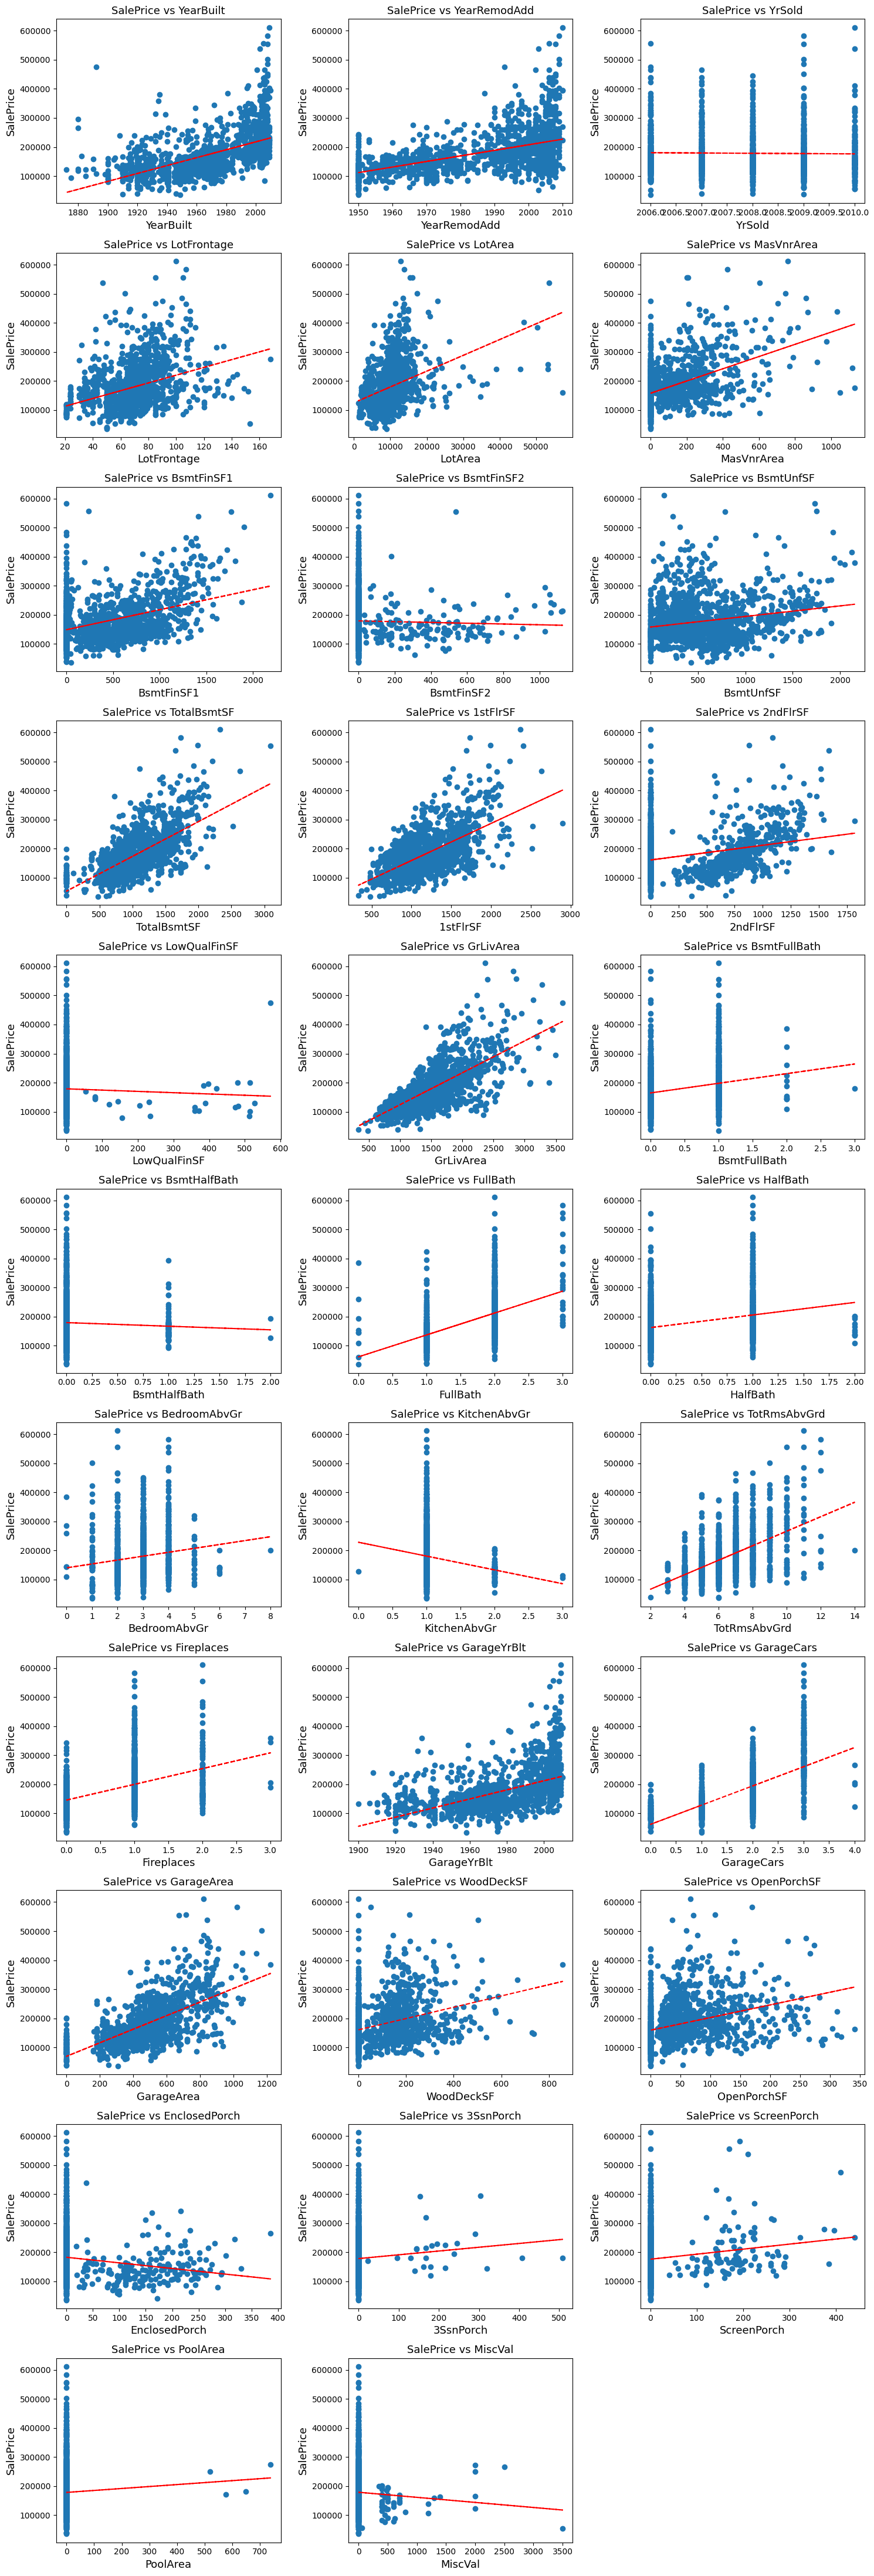

In [20]:
# Pemilihan variabel independen
indep_var = [x for x in df_train[data_numerik] if x not in ['Id', 'SalePrice']]

# Menghitung jumlah baris dan kolom subplot yang dibutuhkan
num_plots = len(indep_var)
num_cols = 3  # Jumlah kolom yang diinginkan (sesuaikan sesuai preferensi)
num_rows = int(np.ceil(num_plots / num_cols))  # Menghitung jumlah baris yang dibutuhkan

# Membuat figure dan axes untuk subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))

# Flatten axes jika hanya ada satu baris
axes = axes.flatten()

# Melakukan loop untuk setiap variabel independen
for i, var in enumerate(indep_var):
    # Scatter plot
    axes[i].scatter(df_train[var], df_train['SalePrice'])
    
    # Menghitung garis regresi linear
    z = np.polyfit(df_train[var], df_train['SalePrice'], 1)
    p = np.poly1d(z)
    
    # Menambahkan garis linear ke plot
    axes[i].plot(df_train[var], p(df_train[var]), "r--")
    
    # Set judul dan label
    axes[i].set_title(f'SalePrice vs {var}', fontsize=13)
    axes[i].set_xlabel(var, fontsize=13)
    axes[i].set_ylabel('SalePrice', fontsize=13)

# Menghilangkan subplot yang tidak terpakai (jika ada)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menampilkan gambar
plt.tight_layout()
plt.show()

In [21]:
# Membuat variabel dummy untuk kolom kategorik dengan jumlah varibel k-1
categorical_var = [x for x in data_kategorik if x not in ['Alley', 'MiscFeature', 'PoolQC', 'Fence']]

df_train_dummies = pd.get_dummies(df_train, columns=categorical_var, drop_first=True)
df_dummy = df_train_dummies.applymap(lambda x: 1 if x == True else (0 if x == False else x))

df_dummy

C:\Users\Adnan\AppData\Local\Temp\ipykernel_8804\1680341782.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_dummy = df_train_dummies.applymap(lambda x: 1 if x == True else (0 if x == False else x))


,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,...,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65,8450,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2008,208500,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
1,2,80,9600,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,2007,181500,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,3,68,11250,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,2008,223500,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
3,4,60,9550,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2006,140000,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
4,5,84,14260,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,2008,250000,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62,7917,1999,2000,0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999,2,460,0,40,0,0,0,0,0,2007,175000,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
1456,1457,85,13175,1978,1988,119,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978,2,500,349,0,0,0,0,0,0,2010,210000,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
1457,1458,66,9042,1941,2006,0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941,1,252,0,60,0,0,0,0,2500,2010,266500,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
1458,1459,68,9717,1950,1996,0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950,1,240,366,0,112,0,0,0,0,2010,142125,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,

In [22]:
# gabungkan seluruh dummy dan numerik
number = pd.DataFrame(df_train[[x for x in df_train[data_numerik] if x not in ['Id']]])
df_dummy

dftrain_final = pd.concat([number, df_dummy], axis=1)

In [23]:
df_transposed = dftrain_final.T

# Identifikasi kolom duplikat
duplicates = df_transposed.duplicated()

# Cetak kolom yang duplikat
print("Kolom duplikat:")
print(df_transposed[duplicates])

# Menghapus kolom duplikat
train_final = dftrain_final.loc[:, ~duplicates]

Kolom duplikat:
                      0       1       2       3       4       5       6     \
LotFrontage             65      80      68      60      84      85      75   
LotArea               8450    9600   11250    9550   14260   14115   10084   
YearBuilt             2003    1976    2001    1915    2000    1993    2004   
YearRemodAdd          2003    1976    2002    1970    2000    1995    2005   
MasVnrArea             196       0     162       0     350       0     186   
BsmtFinSF1             706     978     486     216     655     732    1369   
BsmtFinSF2               0       0       0       0       0       0       0   
BsmtUnfSF              150     284     434     540     490      64     317   
TotalBsmtSF            856    1262     920     756    1145     796    1686   
1stFlrSF               856    1262     920     961    1145     796    1694   
2ndFlrSF               854       0     866     756    1053     566       0   
LowQualFinSF             0       0       0      

### Modelling


In [24]:
train_final.shape

(1431, 270)

In [26]:
# membuat model Lasso Regression
# Train test split

X = train_final.drop(['SalePrice'], axis=1)
y = train_final['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21) # 20% data digunakan untuk testing


In [27]:
# Model Lasso dengan semua variabel (270 variabel)

ls = Lasso(alpha=1)
ls.fit(X_train, y_train)

y_pred_ls = ls.predict(X_test)


# Ambil koefisien
ls_coef = ls.coef_

intercept = ls.intercept_
print("Nilai intercept: ", intercept)

for i, coefficient in enumerate(ls_coef):
    print("koefisien {}: {}".format(i, coefficient))

print(pd.DataFrame(y_pred_ls))


Nilai intercept:  -1258584.6281576825
koefisien 0: 416.60754339641613
koefisien 1: 135.79122773070966
koefisien 2: 89.26859907356359
koefisien 3: -20.493900133388262
koefisien 4: 1.3240434308333706
koefisien 5: 11.232138551383093
koefisien 6: 27.4352615683374
koefisien 7: 20.36488724904543
koefisien 8: 11.362681197128062
koefisien 9: 8.695163815141434
koefisien 10: 42.352868354608766
koefisien 11: 50.893766987958145
koefisien 12: 32.31202945243504
koefisien 13: 8.781042111948127
koefisien 14: -48.02177981004468
koefisien 15: 177.61143400516872
koefisien 16: 3504.565343038746
koefisien 17: 3293.981219544581
koefisien 18: -3496.7345843102876
koefisien 19: -2322.885377020518
koefisien 20: 1275.1338010904853
koefisien 21: 2363.277064064782
koefisien 22: -15.151230609750314
koefisien 23: 1944.8373438315843
koefisien 24: 18.55048080793417
koefisien 25: 8.137593081516062
koefisien 26: 16.743889275199113
koefisien 27: 20.149805028481037
koefisien 28: 25.08680104498991
koefisien 29: 53.21711315

c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e+11, tolerance: 6.736e+08
  model = cd_fast.enet_coordinate_descent(


In [28]:
# Metric R-squared dan RMSE
mse_lasso = mean_squared_error(y_test, y_pred_ls)
rmse_lasso = np.sqrt(mse_lasso)
r2_lasso = r2_score(y_test, y_pred_ls)

rmse_lasso

21541.841564751092

In [29]:
# Model kedua: RandomForest Regressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

"""# Menyimpan nilai prediksi
df_rf = pd.DataFrame(y_pred_rf)
df_rf.head(10)"""

print(pd.DataFrame(y_pred_rf))


             0
0    161756.32
1    153374.84
2    211195.40
3    114358.87
4    129442.58
..         ...
282  189379.68
283  133381.02
284  139167.80
285  159910.87
286  139471.25

[287 rows x 1 columns]


In [30]:
# RMSE : RandomForest Regressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf

23407.895226125063

In [31]:
# akan dilakukan hyperparameter tunning

rf_model = RandomForestRegressor(random_state=21)

param_grid = {
    'n_estimators': [x for x in range(1, 500, 50)],
    "max_depth" : [x for x in range(6,10,2)] }


# Inisialisasi GridSearchCV dengan model RandomForestRegressor dan parameter grid
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Lakukan hyperparameter tuning pada data latih
grid_search.fit(X_train, y_train)

# Cetak hyperparameter terbaik yang ditemukan
print("Hyperparameter terbaik:", grid_search.best_params_)


Hyperparameter terbaik: {'max_depth': 8, 'n_estimators': 51}


In [32]:
# cross validation

# Cross Validation: RandomForest
model_rf = RandomForestRegressor()

scores_rf = cross_val_score(model_rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_rf = -scores_rf

# Cross Validation : Ridge
model_lasso = Lasso()

scores_lasso = cross_val_score(model_lasso, X, y, cv=5, scoring='neg_root_mean_squared_error')
rmse_lasso = -scores_lasso

c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e+11, tolerance: 6.496e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+11, tolerance: 6.229e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Adnan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [33]:
print("Mean Cross-Validation Lasso: ", rmse_lasso.mean())
print("Mean Cross-Validation Random Forest: ", rmse_rf.mean())

Mean Cross-Validation Lasso:  23400.916570735506
Mean Cross-Validation Random Forest:  25382.342451738037


In [34]:
y_pred_ls
y_pred_rf

prediksi = pd.concat([pd.DataFrame(y_pred_ls), pd.DataFrame(y_pred_rf)], axis=1)
prediksi.columns = ['Lasso Prediction', 'RandomForest Prediction']

prediksi

,Lasso Prediction,RandomForest Prediction
0,174204.757192,161756.32
1,163852.543438,153374.84
2,207611.242655,211195.40
3,99984.834795,114358.87
4,110088.160705,129442.58
...,...,...
282,198075.838363,189379.68
283,145714.448276,133381.02
284,143853.935743,139167.80
285,188865.694147,159910.87
